In [ ]:
!wget ftp://ftp.ensembl.org/pub/release-85/gff3/homo_sapiens/Homo_sapiens.GRCh38.85.gff3.gz
!wget ftp.ensembl.org/pub/release-85/gff3/homo_sapiens/README

In [ ]:
!mv Homo_sapiens.GRCh38.85.gff3.gz ../datasets

In [ ]:
!zcat ../datasets/Homo_sapiens.GRCh38.85.gff3.gz | head -n 50 # what is zcat command?

In [ ]:
!mv README ../datasets

## Action item for class: Download the sequence and the README file, save in the relevant folder and inspect it: What information do you see? How many columns will be in the original dataframe?

According to the README, ## means the metadata is stable, while #! means it’s experimental.

Human readable comments are supposed to be after a single #. For simplicity, we will treat all lines starting with # as comments, and simply ignore them during our analysis.

In [ ]:
# some lines in the file we can see

##gff-version   3
##sequence-region   1 1 248956422
##sequence-region   10 1 133797422
##sequence-region   11 1 135086622
##sequence-region   12 1 133275309

##sequence-region   MT 1 16569
##sequence-region   X 1 156040895
##sequence-region   Y 2781480 56887902
#!genome-build  GRCh38.p7
#!genome-version GRCh38
#!genome-date 2013-12
#!genome-build-accession NCBI:GCA_000001405.22
#!genebuild-last-updated 2016-06

## Action item for class: What features (column names) do you think could be informative and what are trivial?

This is the annotation of the first chromosome with a seqid of 1, which starts from the first base to the 24,895,622nd base, i.e., the first chromosome is ~ 25 million bases long.

Our analysis won’t need information from the three columns with a value of . (i.e. score, strand, and phase), so we can simply ignore them for now.

The last attributes column says Chromosome 1 also has three alias names, namely CM000663.2, chr1, and NC_000001.11. That’s basically what a GFF3 file looks like, but we won’t inspect them line by line, so it’s time to load the whole file into Pandas.

Pandas is good fit for dealing with GFF3 format because it is a tab-delimited file, and Pandas has very good support for reading CSV-like files.


In [ ]:
import pandas as pd
pd.__version__ # good idea to report it when comparing code from different times
col_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'] #specified in README file
df = pd.read_csv('../datasets/Homo_sapiens.GRCh38.85.gff3.gz', compression='gzip',
                         sep='\t', comment='#', low_memory=False,
                         header=None, names=col_names)

In [ ]:
df.head(10)

In [ ]:
# Next, let’s get some basic information about this dataframe with the .info method.

df.info()

In [ ]:
#df.describe() #any useful?

In [ ]:
!gunzip -c ../datasets/Homo_sapiens.GRCh38.85.gff3.gz > /tmp/tmp.gff3 && du -s /tmp/tmp.gff3

In [ ]:
!gunzip -c ../datasets/Homo_sapiens.GRCh38.85.gff3.gz > /tmp/tmp.gff3 && du -sh /tmp/tmp.gff3

In [ ]:
# Now, let’s see what the first column seqid is all about

df.seqid.unique()

In [ ]:
df.seqid.unique().shape #when will this not work?

#df['seqid'].unique().shape

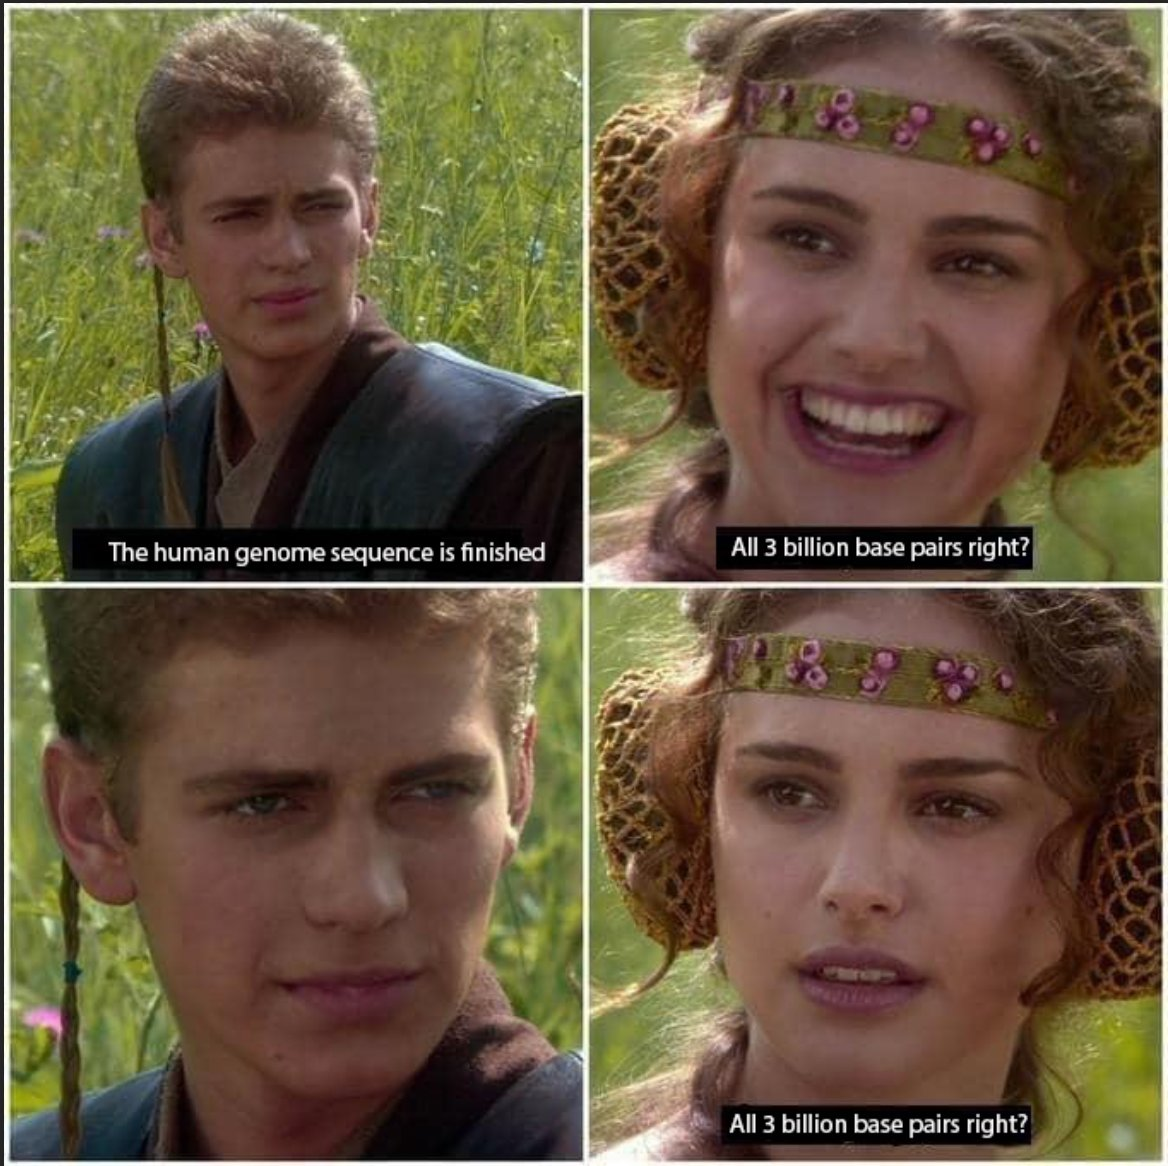

Although the first human genome draft came out more than 15 years ago, the current human genome is still incomplete. 

Why? 

The difficulty in assembling these sequences is in large part due to complex repetitive regions in the genome.

Now it is time to take a look at the source column.

The README says that the source is a free text qualifier intended to describe the algorithm or operating procedure that generated this feature.

In [ ]:
df.source.value_counts()

# How Much of the Genome Is Incomplete?

The information about each entire chromosome is in the entries from source GRCh38, so let’s first filter out the rest, and assign the filtered result to a new variable gdf.

In [ ]:
gdf = df[df.source == 'GRCh38'] #only returning those entries that match to GRCh38
gdf.shape

In [ ]:
gdf.sample(10) #randomly select 10 entries

# what was the other method we learned to randomly sample values?

In [ ]:
gdf = gdf.copy() # let's make a copy and refrain from using the original dataframe

#making a new column 'length', storing length information for each seqid entry
gdf['length'] = gdf.end - gdf.start + 1 
gdf.head()

Here, we first made a copy of gdf with .copy(). Otherwise, the original gdf is just a slice of df, and modifying it directly would result in [SettingWithCopyWarning](https://www.dataquest.io/blog/settingwithcopywarning/).

In [ ]:
# We then calculate the length of each entry and add it back to gdf as a new column named “length”. 
#The total length turns out to be about 3.1 billion, 
#and the fraction of unassembled sequences is about 0.37%.

gdf.length.sum()

In [ ]:
# First, we create a list of strings that covers all seqids of well assembled sequences, 
# which are all chromosomes and mitochondria. 
# We then use the isin method to filter all entries whose seqid are in the chrs list.
chrs = [str(_) for _ in range(1, 23)] + ['X', 'Y', 'MT']
chrs

In [ ]:
# gdf.seqid.isin(chrs) # we want to know the quantity of those that return False

# gdf[-gdf.seqid.isin(chrs)] #how many?

# gdf[gdf.seqid.isin(chrs)].length.sum() / gdf.length.sum()

In [ ]:
# A minus sign (-) is added to the beginning of the index to reverse the selection, 
# because we actually want everything that is not in the list 
# (in this case, we want the unassembled ones starting with KI and GL)
gdf[-gdf.seqid.isin(chrs)].length.sum() / gdf.length.sum()

In [ ]:
# Note: Since the assembled and unassembled sequences are distinguished by the type column, 
# the last line can alternatively be rewritten as follows to obtain the same results.

gdf[(gdf['type'] == 'supercontig')].length.sum() / gdf.length.sum()


# How Many Genes Are There?

Here we focus on the entries from source ensembl, havana and ensembl_havana since they’re where the majority of the annotation entries belong. There is only 194 entries for source GRCh38.

In [ ]:
edf = df[df.source.isin(['ensembl', 'havana', 'ensembl_havana'])]
edf.sample(10)

In [ ]:
edf.type.value_counts()

In [ ]:
# let's make another dataframe where we will only care for the genes
ndf = edf[edf.type == 'gene']
ndf = ndf.copy() # let's make a copy
ndf.sample(10).attributes.values #let's get random rows and check the attributes column content

### [Regex cheatsheet](https://medium.com/factory-mind/regex-tutorial-a-simple-cheatsheet-by-examples-649dc1c3f285)

In [ ]:
import re

RE_GENE_NAME = re.compile(r'Name=(?P<gene_name>.+?);') #look up and tell me how it works
def extract_gene_name(attributes_str):
    res = RE_GENE_NAME.search(attributes_str)
    return res.group('gene_name')

ndf['gene_name'] = ndf.attributes.apply(extract_gene_name)

In [ ]:
# hint
# every gene_id must start with ENSG, where ENS means ensembl and G means gene.

RE_GENE_ID = re.compile(r'gene_id=(?P<gene_id>ENSG.+?);')
def extract_gene_id(attributes_str):
    res = RE_GENE_ID.search(attributes_str)
    return res.group('gene_id')

ndf['gene_id'] = ndf.attributes.apply(extract_gene_id)

In [ ]:
# help(re.compile)

In [ ]:
# hint
# not all entries have description, so we will return an empty string for those. 

RE_GENE_DESC = re.compile(r'description=(?P<description>.+?);')
def extract_gene_desc(attributes_str):
    res = RE_GENE_DESC.search(attributes_str)
    if res is None:
        return ''
    else:
        return res.group('description')

ndf['description'] = ndf.attributes.apply(extract_gene_desc)

In [ ]:
# After everything is extracted, we won’t use the attributes column anymore, so let’s drop it to keep things nice and clean with the method .drop:
ndf.drop('attributes', axis=1, inplace=True)
ndf.head()

In [ ]:
ndf.shape

In [ ]:
ndf.gene_id.unique().shape

In [ ]:
ndf.gene_name.unique().shape

In [ ]:
count_df = ndf.groupby('gene_name').count().iloc[:, 0].sort_values().iloc[::-1]
count_df.head(10)

## iloc returns a Pandas Series when one row is selected, and a Pandas DataFrame when multiple rows are selected, or if any column in full is selected
## [More information on how iloc works](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html)

In [ ]:
mydict = [{'a': 1, 'b': 2, 'c': 3, 'd': 4},
          {'a': 100, 'b': 200, 'c': 300, 'd': 400},
          {'a': 1000, 'b': 2000, 'c': 3000, 'd': 4000 }]
df_d = pd.DataFrame(mydict)
df_d

In [ ]:
df_d.iloc[0] #get first row
#type(df.iloc[0])

In [ ]:
df_d.iloc[[0]] #get first row
#type(df.iloc[[0]])

In [ ]:
df_d.iloc[:, 0] #get first column
#type(df_d.iloc[:, 0])

In [ ]:
df_d.iloc[[0, 1]]

In [ ]:
df_d.iloc[::-1] #get reverse order for rows

### Back to our genome dataframe

In [ ]:
ndf[ndf.gene_name == 'SCARNA20']

# How Long Is a Typical Gene?

Similar to what we did when we were trying to understand the incompleteness of the genome, we can easily add a length column to ndf:

In [ ]:
ndf['length'] = ndf.end - ndf.start + 1 
ndf.head()

In [ ]:
ndf.length.describe()

In [ ]:
import matplotlib.pyplot as plt

ndf.length.plot(kind='hist', bins=50, logy=True)
plt.show()

In [ ]:
ndf[ndf.length > 2e6].sort_values('length').iloc[::-1]

In [ ]:
ndf.sort_values('length').head()

## Action item for the class: What are these short genes? Can you find some information and share with the class?

# Gene Distribution Among Chromosomes

The last thing I’d like to discuss is gene distribution among chromosomes, which also serves as an example for introducing the .merge method for combining two DataFrames. Intuitively, longer chromosomes likely host more genes. Let’s see if that is true.

In [ ]:
ndf = ndf[ndf.seqid.isin(chrs)]

In [ ]:
chr_gene_counts = ndf.groupby('seqid').count().iloc[:, 0].sort_values().iloc[::-1]
chr_gene_counts

In [ ]:
print(len(df)) #GFF3 dataset
print(len(gdf)) #GFF3 dataset but only returning those entries that match to GRCh38
print(len(edf)) # GFF3 dataset but only returning entries from source ensembl, havana and ensembl_havana
print(len(ndf)) # GFF3 dataset with type gene, and only returning entries from source ensembl, havana and ensembl_havana

In [ ]:
df[(df.type == 'gene') & (df.seqid == 'MT')]

In [ ]:
gdf = gdf[gdf.seqid.isin(chrs)] # you can also decide to make a copy, instead of using the df directly
gdf.drop(['start', 'end', 'score', 'strand', 'phase' ,'attributes'], axis=1, inplace=True)
gdf.sort_values('length').iloc[::-1]

In [ ]:
chr_gene_counts.head() 
type(chr_gene_counts)

#not a pandas df, we can't merge datasets unless they are of the same data type

In [ ]:
cdf = chr_gene_counts.to_frame(name='gene_count').reset_index()
#.reset_index() converts the original index (i.e. seqid) into a new column and resets current index as 0-based incremental numbers.
cdf.head(2)

In [ ]:
type(cdf) # now it is a pandas df

In [ ]:
merged = gdf.merge(cdf, on='seqid')
merged

# Is there a correlation between chromosome length and gene_count?

In [ ]:
merged[['length', 'gene_count']].corr()

In [ ]:
ax = merged[['length', 'gene_count']].sort_values('length').plot(x='length', y='gene_count', style='o-')
# add some margin to both ends of x axis
xlim = ax.get_xlim()
margin = xlim[0] * 0.1
ax.set_xlim([xlim[0] - margin, xlim[1] + margin])
# Label each point on the graph
for (s, x, y) in merged[['seqid', 'length', 'gene_count']].sort_values('length').values:
    ax.text(x, y - 100, str(s))

# Findings

# Future research (homework)

# Using the GFF3 file that is well annotated, find out:

1. Visualize the data as much as you can. How many genes/CDS/exon are listed for ENSEMBL and other datasets?
2. Plot a histogram of length information for a) entire genome, 2) for each source, i.e., ENSEMBL, Havana, etc. separately (can use subplot)
3. Parse the description column: Anything you can visualize? Visualize at least one thing.
4. How many transcripts does a gene typically have? What percentage of genes have more than 1 transcript? Hint: You will need to sum up the exon lengths to get the transcripts. You can use external libraries. 

Resources to check out
1. https://daler.github.io/gffutils/
2. http://seqanswers.com/forums/showthread.php?t=4914

See also

   ### [The GFF spec can be found here](https://www.sanger.ac.uk/resources/software/gff/spec.html)
   ### [A great explanation on the GFF format can be found here](http://gmod.org/wiki/GFF3)